In [1]:
# imports
import sys
sys.path.append('../')

from glob import glob
from src.load_data import master_load
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, MaxPooling1D, Reshape)
from tensorflow.math import confusion_matrix

In [2]:
# set plotting params
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 32
plt.rcParams['axes.labelsize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 32
plt.rcParams['figure.titlesize'] = 48

In [3]:
X_train, X_test, y_train, y_test = master_load()

In [4]:
# modified
model = Sequential()

model.add(Conv1D(64, (3), input_shape=X_train.shape[1:]))
model.add(Activation('selu'))

model.add(Conv1D(64, (2)))
model.add(Activation('selu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2)))
model.add(Activation('selu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(4))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
epochs = 5

batch_size = 64

for epoch in range(epochs):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    model_name = f'../models/numpy/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'
    model.save(model_name)
    
print('done')

551/551 [==============================] - 1s 1ms/step - loss: 1.9595 - accuracy: 0.4190
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.419-loss_1.96-1628147466.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 3.0559 - accuracy: 0.4138
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.414-loss_3.06-1628147501.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 3.3854 - accuracy: 0.4119
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.412-loss_3.39-1628147542.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 4.6711 - accuracy: 0.4090
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.409-loss_4.67-1628147578.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 5.0830 - accuracy: 0.4192
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.419-loss_5.08-1628147619.model/assets
done


In [18]:
# modified
model = Sequential()

model.add(Conv1D(64, (3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(4))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
epochs = 5

batch_size = 64

for epoch in range(epochs):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    model_name = f'../models/numpy/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'
    model.save(model_name)
    
print('done')

551/551 [==============================] - 1s 921us/step - loss: 1.2916 - accuracy: 0.4515
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.452-loss_1.29-1628147660.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 1.8378 - accuracy: 0.4189
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.419-loss_1.84-1628147695.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 2.3183 - accuracy: 0.4314
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.431-loss_2.32-1628147739.model/assets
551/551 [==============================] - 1s 959us/step - loss: 2.6531 - accuracy: 0.4130
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.413-loss_2.65-1628147776.model/assets
551/551 [==============================] - 1s 951us/step - loss: 3.3001 - accuracy: 0.4191
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.419-loss_3.3-1628147810.model/assets
done


In [19]:
epochs = 50

batch_size = 64

for epoch in range(epochs):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    model_name = f'../models/numpy/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'
    model.save(model_name)
    
print('done')

551/551 [==============================] - 1s 1ms/step - loss: 1.3839 - accuracy: 0.4285
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.429-loss_1.38-1628165350.model/assets
551/551 [==============================] - 1s 952us/step - loss: 2.2428 - accuracy: 0.3984
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.398-loss_2.24-1628165401.model/assets
551/551 [==============================] - 1s 981us/step - loss: 2.4100 - accuracy: 0.3854
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.385-loss_2.41-1628165451.model/assets
551/551 [==============================] - 1s 986us/step - loss: 3.0604 - accuracy: 0.3936
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.394-loss_3.06-1628165502.model/assets
551/551 [==============================] - 1s 953us/step - loss: 4.2119 - accuracy: 0.3816
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.382-loss_4.21-1628165551.model/assets
551/551 [==============================] - 1s 1ms/step - loss: 4.6203 - 

In [8]:
# stolen 1
model = Sequential()

model.add(Conv1D(64, (3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(128))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
epochs = 5

batch_size = 64

for epoch in range(epochs):
    model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    model_name = f'../models/numpy/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'
    model.save(model_name)
    
print('done')

551/551 [==============================] - 2s 3ms/step - loss: 1.6747 - accuracy: 0.3864
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.386-loss_1.67-1628147862.model/assets
551/551 [==============================] - 2s 3ms/step - loss: 3.0284 - accuracy: 0.3663
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.366-loss_3.03-1628147917.model/assets
551/551 [==============================] - 1s 2ms/step - loss: 3.5113 - accuracy: 0.3559
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.356-loss_3.51-1628147968.model/assets
551/551 [==============================] - 1s 2ms/step - loss: 3.7877 - accuracy: 0.3893
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.389-loss_3.79-1628148019.model/assets
551/551 [==============================] - 1s 3ms/step - loss: 4.7810 - accuracy: 0.3725
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.372-loss_4.78-1628148075.model/assets
done


In [10]:
reshape = (-1, 16, 60)

train_X = np.clip(np.array(X_train).reshape(reshape), -10, 10) / 10
test_X = np.clip(np.array(X_test).reshape(reshape), -10, 10) / 10

In [11]:
# stolen 2
model = Sequential()

model.add(Conv1D(64, (5), padding='same', input_shape=train_X.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(128, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(256, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(512, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(3, (16)))
model.add(Reshape((3,)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
epochs = 100

batch_size = 64

for epoch in range(epochs):
    model.fit(train_X, y_train, batch_size=batch_size, epochs=1, validation_data=(test_X, y_test))
    score = model.evaluate(test_X, y_test, batch_size=batch_size)
    
    model_name = f'../models/numpy/acc_{round(score[1], 3)}-loss_{round(score[0], 2)}-{int(time.time())}.model'
    model.save(model_name)
    
print('done')

551/551 [==============================] - 7s 12ms/step - loss: 3.0223 - accuracy: 0.3986
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.399-loss_3.02-1628148221.model/assets
551/551 [==============================] - 5s 9ms/step - loss: 4.7123 - accuracy: 0.3992
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.399-loss_4.71-1628148366.model/assets
551/551 [==============================] - 6s 11ms/step - loss: 5.2278 - accuracy: 0.3898
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.39-loss_5.23-1628148514.model/assets
551/551 [==============================] - 6s 10ms/step - loss: 5.2359 - accuracy: 0.4163
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.416-loss_5.24-1628148662.model/assets
551/551 [==============================] - 5s 10ms/step - loss: 6.3727 - accuracy: 0.3592
INFO:tensorflow:Assets written to: ../models/numpy/acc_0.359-loss_6.37-1628148812.model/assets
551/551 [==============================] - 7s 12ms/step - loss: 7.0497 - accu

In [13]:
best_model = sorted(glob('../models/numpy/*.model'))[-1]

In [14]:
model = tf.keras.models.load_model(best_model)

y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_mat = np.round(np.array(confusion_matrix(y_true, y_pred)) / 11750, 3)

In [15]:
def plot_conf_mat(conf_mat):
    actions = ['left', 'none', 'right']

    fig, ax = plt.subplots(figsize=(16, 9))

    ax.matshow(conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    for i, val0 in enumerate(conf_mat.T):
        for ii, val1 in enumerate(val0):
            ax.text(i, ii, f"{val1}", va='center', ha='center')

    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    plt.show()

<ipython-input-15-f83a402bc218>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+actions)
<ipython-input-15-f83a402bc218>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+actions)


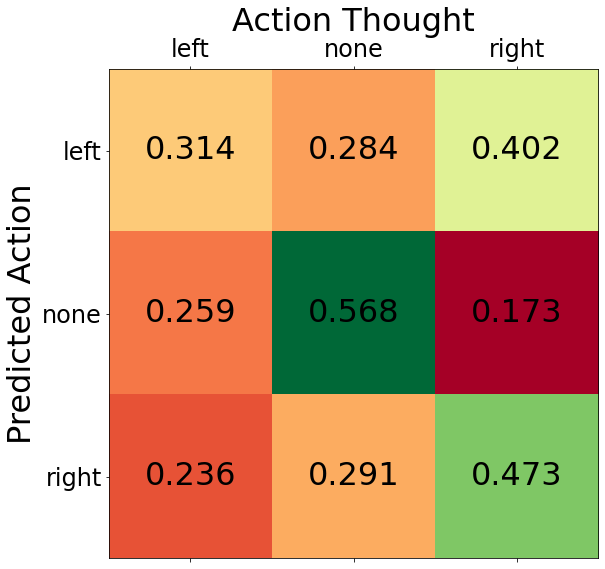

In [16]:
plot_conf_mat(conf_mat)